In [1]:
import joblib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import shap
from scipy.stats import randint, stats, uniform
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold, cross_val_predict
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder, RobustScaler
from xgboost import XGBClassifier

pd.set_option("display.max_columns", None)
sns.set_theme(style="darkgrid")

In [2]:
# Load data in DataFrame
df = pd.read_csv("student_dropout_data.csv")

In [3]:
column_mapping = {
    "Marital status": "statut_matrimonial",
    "Application mode": "mode_de_candidature",
    "Application order": "ordre_de_candidature",
    "Course": "programme",
    "Daytime/evening attendance": "horaire",
    "Previous qualification": "qualification_precedente",
    "Nacionality": "nationalite",
    "Mother's qualification": "qualification_mere",
    "Father's qualification": "qualification_pere",
    "Mother's occupation": "profession_mere",
    "Father's occupation": "profession_pere",
    "Displaced": "deplace",
    "Educational special needs": "besoins_educatifs_speciaux",
    "Debtor": "debiteur",
    "Tuition fees up to date": "frais_scolarite_a_jour",
    "Gender": "genre",
    "Scholarship holder": "bourse",
    "Age at enrollment": "age_inscription",
    "International": "international",
    "Curricular units 1st sem (credited)": "unites_curriculaires_1er_sem_credites",
    "Curricular units 1st sem (enrolled)": "unites_curriculaires_1er_sem_inscrites",
    "Curricular units 1st sem (evaluations)": "unites_curriculaires_1er_sem_evaluations",
    "Curricular units 1st sem (approved)": "unites_curriculaires_1er_sem_approuvees",
    "Curricular units 1st sem (grade)": "note_1er_sem",
    "Curricular units 1st sem (without evaluations)": "unites_curriculaires_1er_sem_sans_evaluations",
    "Curricular units 2nd sem (credited)": "unites_curriculaires_2e_sem_credites",
    "Curricular units 2nd sem (enrolled)": "unites_curriculaires_2e_sem_inscrites",
    "Curricular units 2nd sem (evaluations)": "unites_curriculaires_2e_sem_evaluations",
    "Curricular units 2nd sem (approved)": "unites_curriculaires_2e_sem_approuvees",
    "Curricular units 2nd sem (grade)": "note_2e_sem",
    "Curricular units 2nd sem (without evaluations)": "unites_curriculaires_2e_sem_sans_evaluations",
    "Unemployment rate": "taux_de_chomage",
    "Inflation rate": "taux_inflation",
    "GDP": "pib",
    "Target": "cible"
}

df = df.rename(columns=column_mapping)

In [4]:
df.head()

,statut_matrimonial,mode_de_candidature,ordre_de_candidature,programme,horaire,qualification_precedente,nationalite,qualification_mere,qualification_pere,profession_mere,profession_pere,deplace,besoins_educatifs_speciaux,debiteur,frais_scolarite_a_jour,genre,bourse,age_inscription,international,unites_curriculaires_1er_sem_credites,unites_curriculaires_1er_sem_inscrites,unites_curriculaires_1er_sem_evaluations,unites_curriculaires_1er_sem_approuvees,note_1er_sem,unites_curriculaires_1er_sem_sans_evaluations,unites_curriculaires_2e_sem_credites,unites_curriculaires_2e_sem_inscrites,unites_curriculaires_2e_sem_evaluations,unites_curriculaires_2e_sem_approuvees,note_2e_sem,unites_curriculaires_2e_sem_sans_evaluations,taux_de_chomage,taux_inflation,pib,cible
0,1,8,5,2,1,1,1,13,10,6,10,1,0,0,1,1,0,20,0,0,0,0,0,0.000000,0,0,0,0,0,0.000000,0,10.8,1.4,1.74,Dropout
1,1,6,1,11,1,1,1,1,3,4,4,1,0,0,0,1,0,19,0,0,6,6,6,14.000000,0,0,6,6,6,13.666667,0,13.9,-0.3,0.79,Graduate
2,1,1,5,5,1,1,1,22,27,10,10,1,0,0,0,1,0,19,0,0,6,0,0,0.000000,0,0,6,0,0,0.000000,0,10.8,1.4,1.74,Dropout
3,1,8,2,15,1,1,1,23,27,6,4,1,0,0,1,0,0,20,0,0,6,8,6,13.428571,0,0,6,10,5,12.400000,0,9.4,-0.8,-3.12,Graduate
4,2,12,1,3,0,1,1,22,28,10,10,0,0,0,1,0,0,45,0,0,6,9,5,12.333333,0,0,6,6,6,13.000000,0,13.9,-0.3,0.79,Graduate


In [5]:
df.isna().sum()

statut_matrimonial                               0
mode_de_candidature                              0
ordre_de_candidature                             0
programme                                        0
horaire                                          0
qualification_precedente                         0
nationalite                                      0
qualification_mere                               0
qualification_pere                               0
profession_mere                                  0
profession_pere                                  0
deplace                                          0
besoins_educatifs_speciaux                       0
debiteur                                         0
frais_scolarite_a_jour                           0
genre                                            0
bourse                                           0
age_inscription                                  0
international                                    0
unites_curriculaires_1er_sem_cr

In [6]:
print("Nombre d'enregistrements en double: ", df.duplicated().sum())
df.describe()

Nombre d'enregistrements en double:  0


,statut_matrimonial,mode_de_candidature,ordre_de_candidature,programme,horaire,qualification_precedente,nationalite,qualification_mere,qualification_pere,profession_mere,profession_pere,deplace,besoins_educatifs_speciaux,debiteur,frais_scolarite_a_jour,genre,bourse,age_inscription,international,unites_curriculaires_1er_sem_credites,unites_curriculaires_1er_sem_inscrites,unites_curriculaires_1er_sem_evaluations,unites_curriculaires_1er_sem_approuvees,note_1er_sem,unites_curriculaires_1er_sem_sans_evaluations,unites_curriculaires_2e_sem_credites,unites_curriculaires_2e_sem_inscrites,unites_curriculaires_2e_sem_evaluations,unites_curriculaires_2e_sem_approuvees,note_2e_sem,unites_curriculaires_2e_sem_sans_evaluations,taux_de_chomage,taux_inflation,pib
count,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000
mean,1.178571,6.886980,1.727848,9.899186,0.890823,2.531420,1.254521,12.322107,16.455244,7.317812,7.819168,0.548373,0.011528,0.113698,0.880651,0.351718,0.248418,23.265145,0.024864,0.709991,6.270570,8.299051,4.706600,10.640822,0.137658,0.541817,6.232143,8.063291,4.435805,10.230206,0.150316,11.566139,1.228029,0.001969
std,0.605747,5.298964,1.313793,4.331792,0.311897,3.963707,1.748447,9.026251,11.044800,3.997828,4.856692,0.497711,0.106760,0.317480,0.324235,0.477560,0.432144,7.587816,0.155729,2.360507,2.480178,4.179106,3.094238,4.843663,0.690880,1.918546,2.195951,3.947951,3.014764,5.210808,0.753774,2.663850,1.382711,2.269935
min,1.000000,1.000000,0.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,17.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,7.600000,-0.800000,-4.060000
25%,1.000000,1.000000,1.000000,6.000000,1.000000,1.000000,1.000000,2.000000,3.000000,5.000000,5.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,19.000000,0.000000,0.000000,5.000000,6.000000,3.000000,11.000000,0.000000,0.000000,5.000000,6.000000,2.000000,10.750000,0.000000,9.400000,0.300000,-1.700000
50%,1.000000,8.000000,1.000000,10.000000,1.000000,1.000000,1.000000,13.000000,14.000000,6.000000,8.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,20.000000,0.000000,0.000000,6.000000,8.000000,5.000000,12.285714,0.000000,0.000000,6.000000,8.000000,5.000000,12.200000,0.000000,11.100000,1.400000,0.320000
75%,1.000000,12.000000,2.000000,13.000000,1.000000,1.000000,1.000000,22.000000,27.000000,10.000000,10.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,25.000000,0.000000,0.000000,7.000000,10.000000,6.000000,13.400000,0.000000,0.000000,7.000000,10.000000,6.000000,13.333333,0.000000,13.900000,2.600000,1.790000
max,6.000000,18.000000,9.000000,17.000000,1.000000,17.000000,21.000000,29.000000,34.000000,32.000000,46.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,70.000000,1.000000,20.000000,26.000000,45.000000,26.000000,18.875000,12.000000,19.000000,23.000000,33.000000,20.000000,18.571429,12.000000,16.200000,3.700000,3.510000


### Encode la variable cible en étiquettes.

In [30]:
df["cible_label"] = LabelEncoder().fit_transform(df["cible"])
print(df["cible_label"].value_counts())
print(df["cible"].value_counts())

cible_label
2    2209
0    1421
1     794
Name: count, dtype: int64
cible
Graduate    2209
Dropout     1421
Enrolled     794
Name: count, dtype: int64


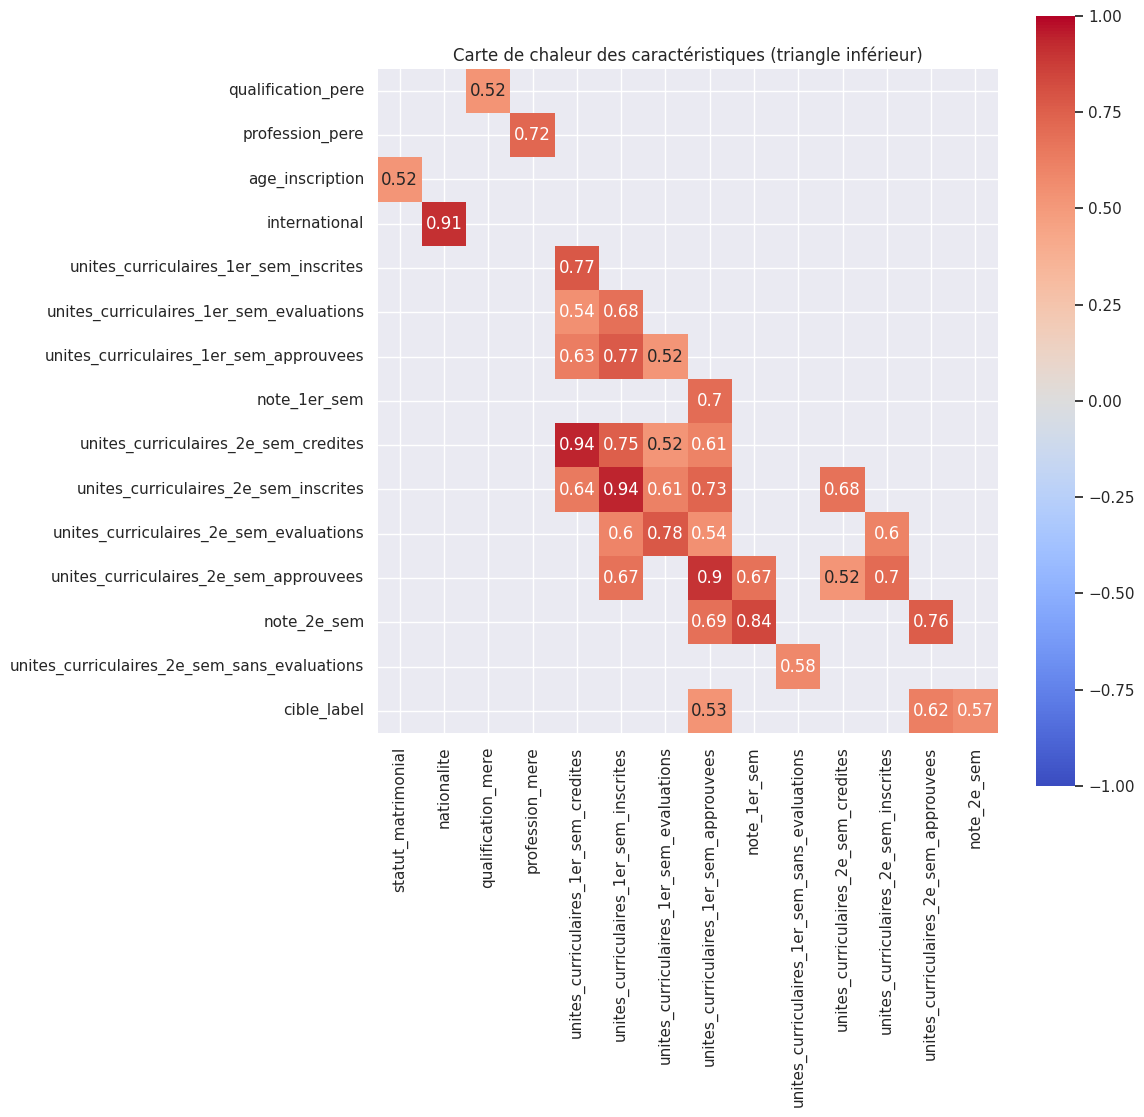

In [10]:
# Calculate the correlation matrix
corr = df.drop("cible", axis=1).corr()

# Remove redundant values on the upper diagonal
mask = np.triu(np.ones_like(corr, dtype=bool))
masked_corr = corr.mask(mask)

# Filter the matrix to keep only correlations >= 0.50 or <= -0.50
threshold = 0.50
filtered_corr = masked_corr[(masked_corr.abs() >= threshold)]

# Drop rows and columns that are NaN (i.e. no correlations above the threshold)
filtered_corr = filtered_corr.dropna(axis=0, how="all").dropna(axis=1, how="all")

_, _ = plt.subplots(figsize=(10, 10))

# Plot heatmap
sns.heatmap(filtered_corr, cmap="coolwarm", annot=True, square=True, vmin=-1, vmax=1)

plt.title("Carte de chaleur des caractéristiques (triangle inférieur)")
plt.savefig("heatmap.png", dpi=300, bbox_inches="tight")

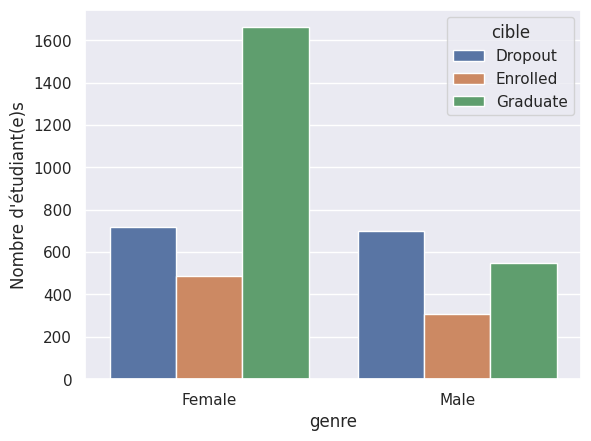

In [11]:
sns.countplot(data=df, x="genre", hue="cible", hue_order=["Dropout", "Enrolled", "Graduate"])
plt.xticks(ticks=[0, 1], labels=["Female", "Male"])
plt.ylabel("Nombre d'étudiant(e)s")
plt.show()

In [12]:
X = df.drop(columns=["cible", "cible_label"])
y = df["cible_label"]

In [13]:
# Create pipeline with RobustScaler and Logistic Regression
lr_pipeline = Pipeline([
    ("scaler", RobustScaler()),
    ("clf", LogisticRegression(
        solver="lbfgs",  # Solver that supports multinomial loss
        max_iter=1000,   # Ensure convergence
        random_state=17  # Reproducibility
    ))
])

In [14]:
y_pred = cross_val_predict(
    lr_pipeline,
    X, y,
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=17)
)

print(classification_report(y, y_pred))

              precision    recall  f1-score   support

           0       0.80      0.77      0.78      1421
           1       0.52      0.31      0.39       794
           2       0.79      0.92      0.85      2209

    accuracy                           0.76      4424
   macro avg       0.70      0.67      0.68      4424
weighted avg       0.74      0.76      0.75      4424



In [15]:
# Train model on all the data
lr_pipeline.fit(X, y)

Pipeline(steps=[('scaler', RobustScaler()),
                ('clf', LogisticRegression(max_iter=1000, random_state=17))])

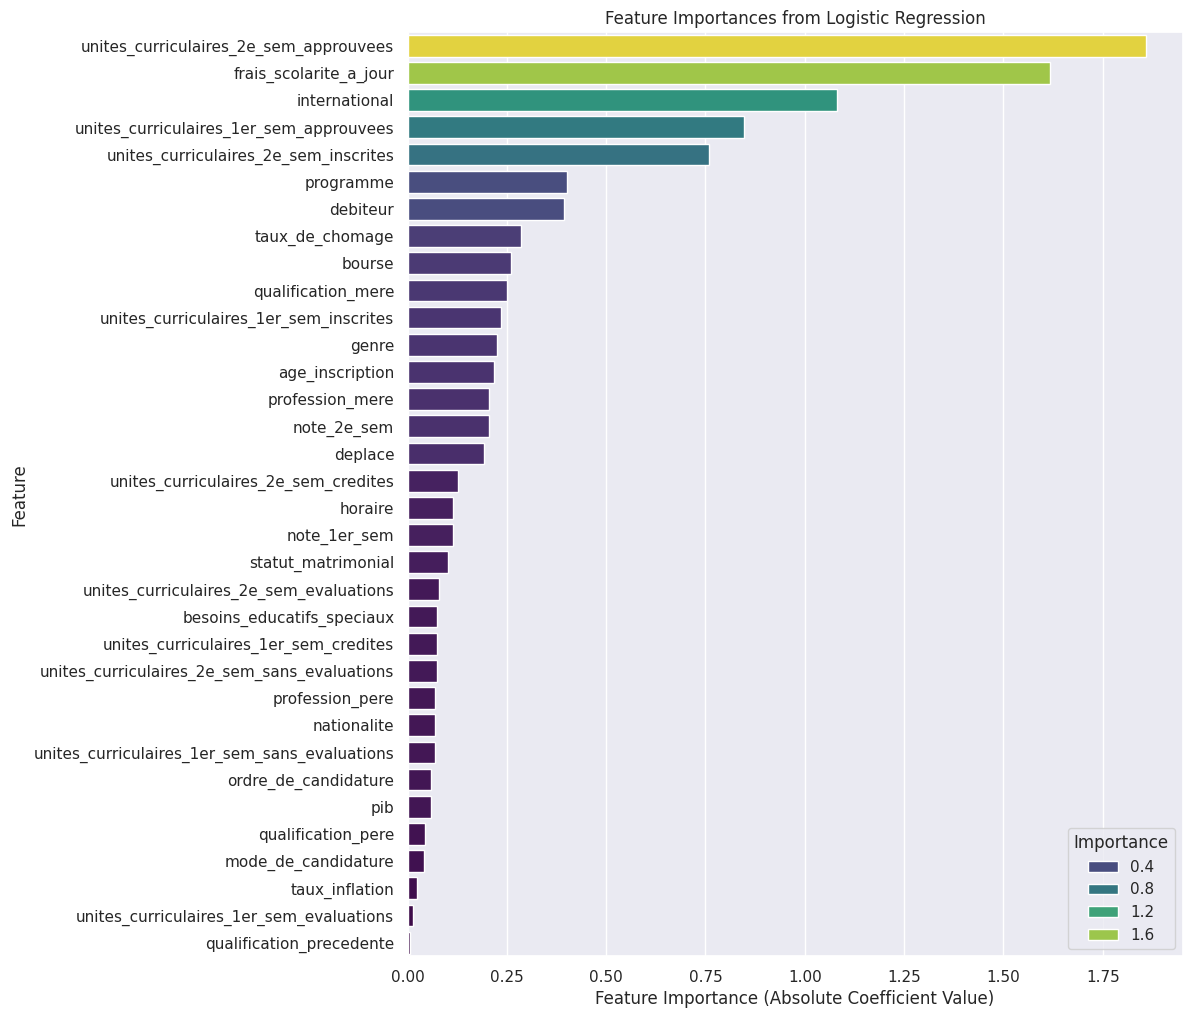

In [17]:
# Access the trained Logistic Regression model from the pipeline
lr_model = lr_pipeline.named_steps["clf"]

# Get the coefficients (feature importances)
coefficients = np.abs(lr_model.coef_[0])
feature_names = X.columns

# Sort features by importance
sorted_indices = np.argsort(coefficients)[::-1]
sorted_coefficients = coefficients[sorted_indices]
sorted_feature_names = feature_names[sorted_indices]

# Create feature importance DataFrame
importances_df = pd.DataFrame({
    "Feature": sorted_feature_names,
    "Importance": sorted_coefficients
})

# Plot using seaborn
plt.figure(figsize=(10, 12))
sns.barplot(data=importances_df, x="Importance", y="Feature", hue="Importance", palette="viridis")
plt.title("Feature Importances from Logistic Regression")
plt.xlabel("Feature Importance (Absolute Coefficient Value)")
plt.ylabel("Feature")
plt.show()

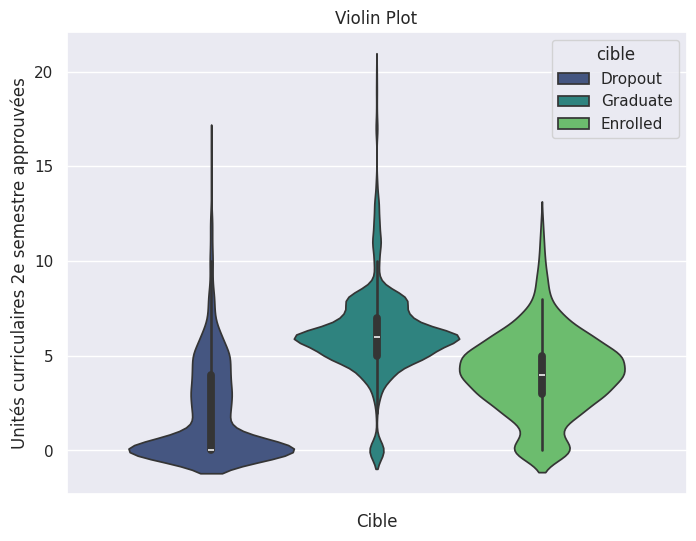

In [18]:
plt.figure(figsize=(8, 6))
sns.violinplot(data=df, hue="cible", y="unites_curriculaires_2e_sem_approuvees", palette="viridis")
plt.title("Violin Plot")
plt.xlabel("Cible")
plt.ylabel("Unités curriculaires 2e semestre approuvées")
plt.show()

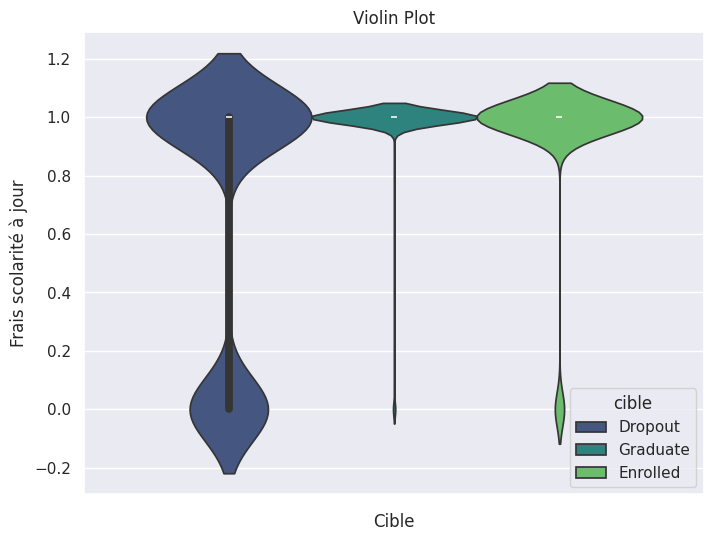

In [19]:
plt.figure(figsize=(8, 6))
sns.violinplot(data=df, hue="cible", y="frais_scolarite_a_jour", palette="viridis")
plt.title("Violin Plot")
plt.xlabel("Cible")
plt.ylabel("Frais scolarité à jour")
plt.show()

In [34]:
# Create pipeline with RobustScaler and XGBoost
xgb_pipeline = Pipeline([
    ("scaler", RobustScaler()),
    ("clf", XGBClassifier(
        objective="multi:softmax",
        num_class=3,
        use_label_encoder=False,
        eval_metric="mlogloss",
        random_state=17
    ))
])

# Define hyperparameter distributions
param_dist = {
    "clf__n_estimators": randint(100, 500),      # Number of trees
    "clf__max_depth": randint(3, 10),            # Maximum depth of a tree
    "clf__learning_rate": uniform(0.01, 0.3),    # Learning rate
    "clf__subsample": uniform(0.7, 0.3),         # Subsample ratio of training data
    "clf__colsample_bytree": uniform(0.7, 0.3),  # Subsample ratio of features
    "clf__reg_alpha": uniform(0, 1),             # L1 regularization (alpha)
    "clf__reg_lambda": uniform(1, 10),           # L2 regularization (lambda)
}

# Define random search
random_search = RandomizedSearchCV(
    xgb_pipeline,
    param_distributions=param_dist,
    n_iter=10,
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=17),
    scoring="f1_macro",  # Use macro-averaged F1 for multi-class classification
    n_jobs=-1,           # Use all available CPU cores
    verbose=1,           # Print progress
    random_state=17
)

In [35]:
random_search.fit(X, y)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=17, shuffle=True),
                   estimator=Pipeline(steps=[('scaler', RobustScaler()),
                                             ('clf',
                                              XGBClassifier(base_score=None,
                                                            booster=None,
                                                            colsample_bylevel=None,
                                                            colsample_bynode=None,
                                                            colsample_bytree=None,
                                                            enable_categorical=False,
                                                            eval_metric='mlogloss',
                                                            gamma=None,
                                                            gpu_id=None,
                                                            importance_type=None,
                                                            interactio...
                                        'clf__n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7f71d58e0d30>,
                                        'clf__reg_alpha': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x7f71d58da200>,
                                        'clf__reg_lambda': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x7f71d58da3b0>,
                                        'clf__subsample': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x7f71d58d9ba0>},
                   random_state=17, scoring='f1_macro', verbose=1)

In [36]:
print("Best parameters:", random_search.best_params_)
print("Best F1 Score (Macro):", random_search.best_score_)

Best parameters: {'clf__colsample_bytree': 0.9550422493278341, 'clf__learning_rate': 0.07940969309767405, 'clf__max_depth': 4, 'clf__n_estimators': 403, 'clf__reg_alpha': 0.2882989975605308, 'clf__reg_lambda': 10.522682541656126, 'clf__subsample': 0.8024880010475353}
Best F1 Score (Macro): 0.7092125621992639


In [20]:
# xgb_best_params = random_search.best_params_

# Best values identified in a previous run
xgb_best_params = {
    "clf__colsample_bytree": 0.9550422493278341,
    "clf__learning_rate": 0.07940969309767405,
    "clf__max_depth": 4,
    "clf__n_estimators": 403,
    "clf__reg_alpha": 0.2882989975605308,
    "clf__reg_lambda": 10.522682541656126,
    "clf__subsample": 0.8024880010475353
}

# Clean hyperparameter names
xgb_best_params_cleaned = {key.replace("clf__", ""): value for key, value in xgb_best_params.items()}

In [21]:
# Create pipeline with RobustScaler and XGBoost
best_xgb_pipeline = Pipeline([
    ("scaler", RobustScaler()),
    ("clf", XGBClassifier(
        **xgb_best_params_cleaned,
        objective="multi:softmax",
        num_class=3,
        # use_label_encoder=False,
        eval_metric="mlogloss",
        random_state=17
    ))
])

In [22]:
y_pred = cross_val_predict(
    best_xgb_pipeline,
    X, y,
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=17)
)

print(classification_report(y, y_pred))

              precision    recall  f1-score   support

           0       0.82      0.77      0.80      1421
           1       0.56      0.43      0.49       794
           2       0.81      0.91      0.86      2209

    accuracy                           0.78      4424
   macro avg       0.73      0.71      0.72      4424
weighted avg       0.77      0.78      0.77      4424



In [23]:
best_xgb_pipeline.fit(X, y)

Pipeline(steps=[('scaler', RobustScaler()),
                ('clf',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.9550422493278341, device=None,
                               early_stopping_rounds=None,
                               enable_categorical=False, eval_metric='mlogloss',
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None,
                               learning_rate=0.07940969309767405, max_bin=None,
                               max_cat_threshold=None, max_cat_to_onehot=None,
                               max_delta_step=None, max_depth=4,
                               max_leaves=None, min_child_weight=None,
                               missing=nan, monotone_constraints=None,
                               multi_strategy=None, n_estimators=403,
                               n_jobs=None, num_class=3, num_parallel_tree=None, ...))])

In [27]:
# Extract the trained XGBoost model from the pipeline
xgb_model = best_xgb_pipeline.named_steps['clf']

# Use SHAP to explain the model
explainer = shap.Explainer(xgb_model, X)
shap_values = explainer(X)

 99%|===================| 13188/13272 [02:24<00:00]       

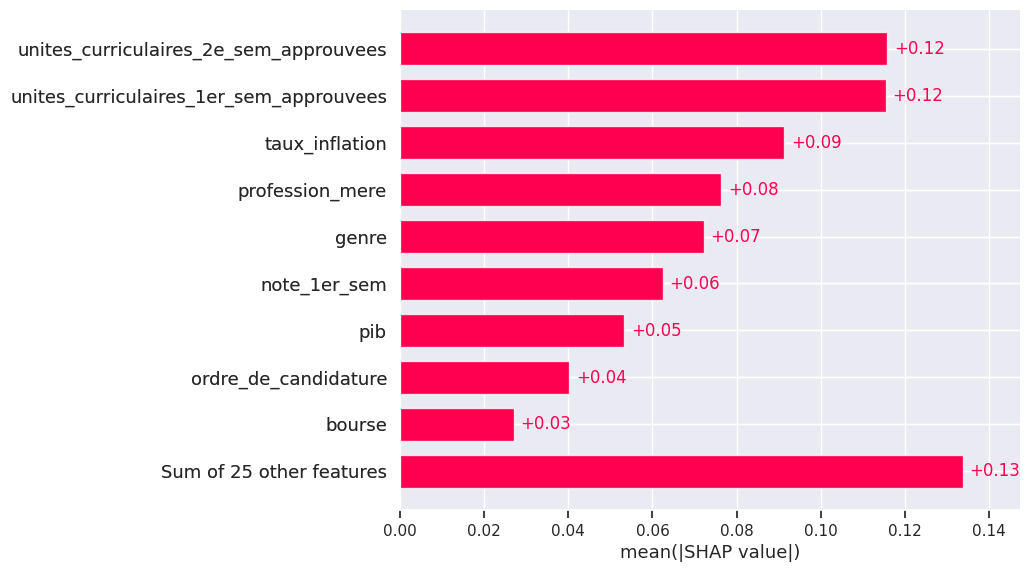

In [33]:
# Visualize feature importance for class 0 (dropout)
shap.plots.bar(shap_values[:, :, 0])

In [16]:
joblib.dump(best_xgb_pipeline, "best_xgb_pipeline.pkl")

['best_xgb_pipeline.pkl']